## CNN architecture for Digit Recognition
![digit](images/digit-recognition.png)

In [1]:
# Import all libraries
import os
import numpy as np
from skimage import io, transform
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
def show_samples(image, digit):
    plt.imshow(image, cmap = 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['digit']
        h, w = image.shape
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'digit': label}

class Resize(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['digit']
        h, w = image.shape
        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        return {'image': img, 'digit': label}
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['digit']
        h, w = image.shape # changed from [:2] to nothing as the images are gray scale
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]



        return {'image': image, 'digit': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['digit']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image[np.newaxis,:,:]
        return {'image': torch.from_numpy(image).float(), 'digit': (torch.from_numpy(np.array([label])))}


In [6]:
class ThreeGramDigitDataset(torch.utils.data.Dataset):
    
    def __init__(self, gt_file, dataset_root, shuffle = False, transform = None):
        
        self.dataset_root = dataset_root
        self.all_file_names = [x.split(' ')[0] for x in open(gt_file).readlines()]
        self.labels = [int(x.split(' ')[1]) for x in open(gt_file).readlines()]
        self.shuffle = shuffle
        
        if self.shuffle:
            temp = list(zip(self.all_file_names, self.labels))
            random.shuffle(temp)
            self.all_file_names, self.labels = zip(*temp)
        
        self.transform = transform
    
    
    def __len__(self):
        return len(self.all_file_names)

        
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.dataset_root, self.all_file_names[idx])
        image = io.imread(img_name)
        sample = {'image': image, 'digit': self.labels[idx]}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample     
        

In [8]:
train_dataset = ThreeGramDigitDataset('3Gram_ann_train.txt', '../../data/lab1/imgFolders/3Gram_Digits', shuffle = False)
#printing the no. of training samples
len(train_dataset)

12150

(0, (48, 104))
(1, (48, 122))
(2, (48, 82))
(3, (48, 104))


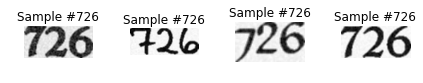

In [9]:
fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(str(sample['digit'])))
    ax.axis('off')
    show_samples(**sample) # way of passing a dictionary
    if i == 3:
        plt.show()
        break

0
(256, 650)
1
(64, 128)


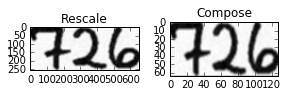

In [10]:
scale = Rescale(256)
crop = RandomCrop(64)
composed = transforms.Compose([Rescale(99),Resize((64,128))])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_dataset[1]

for i, tsfrm in enumerate([scale, composed]):
    print(tsfrm)
    print(i)
    transformed_sample = tsfrm(sample)
    print(transformed_sample['image'].shape)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_samples(**transformed_sample)

plt.show()

In [11]:
train_dataset = ThreeGramDigitDataset('3Gram_ann_train.txt', '../../data/lab1/imgFolders/3Gram_Digits',
                                          shuffle = True, transform=transforms.Compose([
                                               Resize((64,128)),
                                               ToTensor()
                                           ]))
test_dataset = ThreeGramDigitDataset('3Gram_ann_test.txt', '../../data/lab1/imgFolders/3Gram_Digits',
                                          shuffle = True, transform=transforms.Compose([
                                               Resize((64,128)),
                                               ToTensor()
                                           ]))

In [12]:
# Batch the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                        shuffle=False, num_workers=1)

In [14]:
# Model definition
import pdb
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(7540, 50)
        self.fc2_1 = nn.Linear(50, 10)
        self.fc2_2 = nn.Linear(50, 10)
        self.fc2_3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        x = x.view(-1, 7540)
        x = F.relu(self.fc1(x))
        x1 = self.fc2_1(x)
        x2 = self.fc2_2(x)
        x3 = self.fc2_3(x)
        return x1, x2, x3
    
model = Net().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

[1,  2000] loss: 2.786
[2,  2000] loss: 0.666
[3,  2000] loss: 0.389
[4,  2000] loss: 0.315
[5,  2000] loss: 0.267
[6,  2000] loss: 0.219
[7,  2000] loss: 0.218
[8,  2000] loss: 0.193
[9,  2000] loss: 0.185
[10,  2000] loss: 0.178


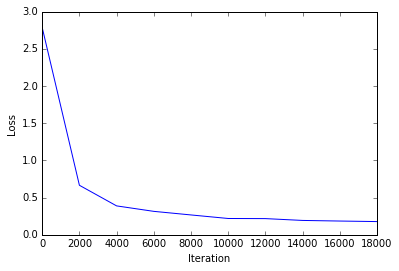

Finished Training


In [15]:
#Training loop

plotIter = 2000
plotIterCntr = 0
numEpochs = 10
trainLoss = np.zeros((plotIter*numEpochs,1))
trainIter = np.arange(plotIter*numEpochs)

for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        
        # get the inputs
        inputs, labels = data['image'], data['digit']
        
        #get each label separately
        labels_1 = torch.div(labels, 100)
        labels_2 = torch.div(torch.fmod(labels, 100), 10)
        labels_3 = torch.fmod(torch.fmod(labels, 100), 10)
        
        # wrap them in Variable
        inputs, labels_1, labels_2, labels_3 = Variable(inputs.cuda()),Variable(labels_1.cuda()), Variable(labels_2.cuda()), Variable(labels_3.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_1, outputs_2, outputs_3 = model(inputs)
        loss = criterion(outputs_1, labels_1[:,0])+criterion(outputs_2, labels_2[:,0])+criterion(outputs_3, labels_3[:,0])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        
        if i % plotIter == plotIter-1:    # print every plotIter mini-batches
            trainLoss[plotIterCntr] = running_loss / plotIter
            plotIterCntr+=1
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / plotIter))
            running_loss = 0.0
            
plt.plot(np.arange(plotIterCntr)*plotIter,trainLoss[0:plotIterCntr], label="train")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

print('Finished Training')


In [17]:
## Prediction of accuracy

import pdb
correct = 0
total = 0

#Iterating over the batches returned from testloader
for data in test_dataloader:
    images, labels = data['image'], data['digit']
        
    outputs_1, outputs_2, outputs_3 = model(Variable(images.cuda()))
    
    _, predicted_1 = torch.max(outputs_1.data, 1)
    _, predicted_2 = torch.max(outputs_2.data, 1)
    _, predicted_3 = torch.max(outputs_3.data, 1)
    
    predicted = predicted_1.mul(100) + predicted_2*10 + predicted_3
    pdb.set_trace()
    total += labels.size(0)
    labels = labels.cuda()
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 1350 test images: %d %%' % (
    100 * correct / total))

> <ipython-input-17-8dc207585030>(19)<module>()
-> total += labels.size(0)
(Pdb) predicted

 758
 559
 373
 445
[torch.cuda.LongTensor of size 4x1 (GPU 0)]

(Pdb) labels

 758
 559
 373
 445
[torch.LongTensor of size 4x1]

(Pdb) c
> <ipython-input-17-8dc207585030>(18)<module>()
-> pdb.set_trace()
(Pdb) predicted

 402
 843
 784
 325
[torch.cuda.LongTensor of size 4x1 (GPU 0)]

(Pdb) labels

 402
 853
 784
 325
[torch.LongTensor of size 4x1]

(Pdb) c
> <ipython-input-17-8dc207585030>(19)<module>()
-> total += labels.size(0)
(Pdb) c
> <ipython-input-17-8dc207585030>(18)<module>()
-> pdb.set_trace()
(Pdb) predicted

 293
 293
 879
 595
[torch.cuda.LongTensor of size 4x1 (GPU 0)]

(Pdb) labels

 293
 293
 879
 595
[torch.LongTensor of size 4x1]

(Pdb) c
> <ipython-input-17-8dc207585030>(19)<module>()
-> total += labels.size(0)
(Pdb) c
> <ipython-input-17-8dc207585030>(18)<module>()
-> pdb.set_trace()
(Pdb) predicted

 703
 396
 611
 581
[torch.cuda.LongTensor of size 4x1 (GPU 0)]

(Pdb) la

Process Process-13:
Traceback (most recent call last):
  File "/users/praveen.krishnan/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return recv()
  File "/users/praveen.krishnan/.local/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
    buf = self.recv_bytes()
KeyboardInterrupt


KeyboardInterrupt: 